## Import Libraries

In [5]:
#imports
import os
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import Parameter
from torch.autograd import Variable
import math

### Task for Increaing Performance

1. Built in VGG, RESNET34, RESNET18, RESNET50 (FZ) ✔

2. Dense Layer ✔

3. Weights and Biases Saved ❌

4. Freezing Layer -- VGG (SGD, ADAM) ✔

5. Dropout -- p = 0.25 ( Result: Decrease Performance) ✔

6. optimizer -- SGD works better ✔

7. Learning rate -- 0.01 works better ✔

8. margin decrease from 0.35 to 0.1 which gives 45.28 accuracy ✔

9. s=2 works better ✔

10. Batch size 100 works better than 32,128 ✔

11. Activation changed ELU, Relu works better than ELU ✔

12. pre-trained - True works better ✔

13. BatchNorm1d works better ✔

14. Laplacian processing is done but doesn't improve result  ✔

15. Center Loss code is implemented but doesn't converge ✔

16. Data is normalized ✔

17. At m = 2, SphereFace performs 48.97% accuracy with (512-256 layers) ✔ 




### Data Loading

In [6]:
#directories

BDSL_TRAIN = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/BDSL/BDSL_split/train'
BDSL_VAL = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/BDSL/BDSL_split/val'
BDSL_TEST = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/BDSL/BDSL_split/test'

ISHARA_AUGMENTED_TRAIN = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_augmentated/Isharalipi_augmentated_split/train'

ISHARA_AUGMENTED_VAL = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_augmentated/Isharalipi_augmentated_split/val'
ISHARA_AUGMENTED_TEST = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_augmentated/Isharalipi_augmentated_split/test'

ISHARA_MAIN = 'E:/Bangla Sign Alphabet/Bangla Sign Alphabet Data/Isharalipi_original/Isharalipi_original_main'

In [7]:
TRAIN_DIRECTORY = ISHARA_AUGMENTED_TRAIN
VAL_DIRECTORY = ISHARA_AUGMENTED_VAL
TEST_DIRECTORY = ISHARA_AUGMENTED_TEST

In [8]:
img_transform = transforms.Compose([transforms.Resize((64,64)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485,0.456,0.406],
                                    std = [0.229,0.224,0.225])])

train_data = ImageFolder(TRAIN_DIRECTORY, transform=img_transform)
val_data = ImageFolder(VAL_DIRECTORY, transform=img_transform)
test_data = ImageFolder(TEST_DIRECTORY, transform=img_transform)

In [9]:
list_of_classes = train_data.class_to_idx
print(list_of_classes)

{'10': 0, '11': 1, '12': 2, '13': 3, '14': 4, '15': 5, '16': 6, '17': 7, '18': 8, '19': 9, '20': 10, '21': 11, '22': 12, '23': 13, '24': 14, '25': 15, '26': 16, '27': 17, '28': 18, '29': 19, '30': 20, '31': 21, '32': 22, '33': 23, '34': 24, '35': 25, '36': 26, '37': 27, '38': 28, '39': 29, '40': 30, '41': 31, '42': 32, '43': 33, '44': 34}


In [10]:
# Device configuration
device = torch.device('cuda')

### Hyperparameters

In [11]:
# Hyper-parameters 
num_epochs = 30
batch_size = 100
learning_rate = 0.01

load_model = False

In [12]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2,shuffle=True, num_workers=4, pin_memory=True)

In [13]:
label = torch.tensor([])
img, label = test_data[5]
print(img.shape, label)

torch.Size([3, 64, 64]) 0


In [14]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

18968
2353
2372


In [15]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


## MODEL 

In [16]:
#load pretrained model
import torchvision.models as models

#model = models.resnet18(pretrained=True)
#model = models.alexnet(pretrained=False)
# model = models.squeezenet1_0(pretrained=True)
#model = models.vgg19(pretrained = True)
#model = models.vgg16(pretrained=True)
#model = models.vgg19_bn(pretrained=True)
# model = models.densenet161(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.googlenet(pretrained=True)
# model = models.shufflenet_v2_x1_0(pretrained=False)
# model = models.mobilenet_v2(pretrained=False)
model = models.resnext50_32x4d(pretrained=True)
# model = models.wide_resnet50_2(pretrained=True)
# model = models.mnasnet1_0(pretrained=True)
#model = models.resnet50(pretrained=True)
#in_features
resnet18 = 512
alexnet = 256*6*6
# squeezenet1_0 = 1000
vgg16 = 512*7*7
# densenet161
# inception_v3
googlenet = 1000
shufflenet_v2_x1_0 = 1000
mobilenet_v2 = 1280
resnext50_32x4d = 1000
# wide_resnet50_2 = 1000
# mnasnet1_0 = 1000
model 

# from torchsummary import summary

# summary(model, (3, 64, 64))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [17]:
# #RESNET

model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=2048,
        out_features=512
    ),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
    torch.nn.Linear(
        in_features=512,
        out_features=256
    ),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
    nn.Linear(in_features=256, out_features=256, bias=True),
)
                      

In [18]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [19]:
# # for param in model.parameters():
# #     param.requires_grad = False

# # model.classifier = nn.Sequential(nn.Linear(in_features=vgg16, out_features=1000, bias=True),
# #                                  nn.ReLU(inplace=True),
                               
# #                                  nn.BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True),
# #                                  nn.Linear(in_features=1000, out_features=256, bias=True),
# #                                  nn.ReLU(inplace=True),
                                 
# #                                  nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
# #                                  nn.Linear(in_features=256, out_features=128, bias=True),
# #                                  ) 

# for param in model.parameters():
#     param.requires_grad = True

# model.classifier = nn.Sequential(nn.Linear(in_features=alexnet, out_features=512, bias=True),
#                                  nn.ReLU(inplace=True),
#                                  nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
#                                  nn.Linear(in_features=512, out_features=256, bias=True),
#                                  nn.ReLU(inplace=True),
#                                  nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
#                                  nn.Linear(in_features=256, out_features=256, bias=True),
#                             )
# model


## Loss Function

In [20]:
class AngleLayer(nn.Module):
    """Convert the fully connected layer of output to """
    def __init__(self, in_planes, out_planes, m=2):
        super(AngleLayer, self).__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.weight = Parameter(torch.Tensor(in_planes, out_planes)).cuda()
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.m = m
        self.cos_val = [
            lambda x: x**0,
            lambda x: x**1,
            lambda x: 2*x**2-1,
            lambda x: 4*x**3-3*x,
            lambda x: 8*x**4-8*x**2+1,
            lambda x: 16*x**5-20*x**3+5*x,
        ]

    def forward(self, input):
        w = self.weight.renorm(2, 1, 1e-5).mul(1e5)
        x_modulus = input.pow(2).sum(1).pow(0.5)
        w_modulus = w.pow(2).sum(0).pow(0.5)

        # W * x = ||W|| * ||x|| * cos(θ)
        inner_wx = input.mm(w)
        cos_theta = inner_wx / x_modulus.view(-1, 1) / w_modulus.view(1, -1)
        cos_theta = cos_theta.clamp(-1, 1)

        cos_m_theta = self.cos_val[self.m](cos_theta)
        theta = Variable(cos_theta.data.acos())
        # k * pi / m <= theta <= (k + 1) * pi / m
        k = (self.m * theta / 3.14159265).floor()
        minus_one = k * 0.0 - 1
        # Phi(yi, i) = (-1)**k * cos(myi,i) - 2 * k
        phi_theta = (minus_one ** k) * cos_m_theta - 2 * k

        cos_x = cos_theta * x_modulus.view(-1, 1)
        phi_x = phi_theta * x_modulus.view(-1, 1)

        return cos_x, phi_x

In [21]:
class AngularSoftmaxWithLoss(nn.Module):
    """"""
    def __init__(self, gamma=0):
        super(AngularSoftmaxWithLoss, self).__init__()
        self.gamma = gamma
        self.iter = 0
        self.lambda_min = 5.0
        self.lambda_max = 1500.0
        self.lamb = 1500.0

    def forward(self, input, target):
        self.iter += 1
        target = target.view(-1, 1)

        index = input[0].data * 0.0
        index.scatter_(0, target.data.view(-1), 0)
        index = Variable(index.byte())

        # Tricks
        # output(θyi) = (lambda * cos(θyi) + (-1) ** k * cos(m * θyi) - 2 * k)) / (1 + lambda)
        #             = cos(θyi) - cos(θyi) / (1 + lambda) + Phi(θyi) / (1 + lambda)
        self.lamb = max(self.lambda_min, self.lambda_max / (1 + 0.1 * self.iter))
        output = input[0] * 1.0
        output[index] -= input[0][index] * 1.0 / (1 + self.lamb)
        output[index] += input[1][index] * 1.0 / (1 + self.lamb)

        # softmax loss
        logit = F.log_softmax(output)
        logit = logit.gather(0, target.data.view(-1))
        pt = logit.data.exp()

        loss = -1 * (1 - pt) ** self.gamma * logit
        loss = loss.mean()

        return loss

In [22]:
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, model, optimizer):
    print('=> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [23]:
# criterion = AngularSoftmaxWithLoss()
criterion = nn.CrossEntropyLoss()
metric_fc = AngleLayer(256,35)

optimizer = torch.optim.Adadelta([{'params': model.parameters()}, {'params': metric_fc.parameters()}],
                                    lr=0.01, weight_decay=0.005)

## Train Loop

In [24]:

def train(num_epochs):
    
    
    print('Starting Training..')
    for e in range(0,num_epochs):
        
            
        print('='*20)
        print(f'Starting epoch {e + 1}/{num_epochs}')
        print('='*20)
        
        train_loss = 0
        
        model.train().to(device)
        
        for train_step, (images, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device).long()
            
            feature = model(images)
            output, _ = metric_fc(feature)
            
            loss = criterion(output, labels)
            
            loss.backward(retain_graph = True)
            optimizer.step()
            
            train_loss += loss.item()
            
            if (train_step) % 100 == 0:
                print ("Evaluating at step", train_step)
                print (f'Epoch [{e+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
            

        train_loss /= (train_step + 1)
        print(f'Training Loss: {train_loss:.4f}')

In [25]:
train(num_epochs)

Starting Training..
Starting epoch 1/30
Evaluating at step 0
Epoch [1/30], Loss: 3.6626
Evaluating at step 100
Epoch [1/30], Loss: 2.4138
Training Loss: 2.5263
Starting epoch 2/30
Evaluating at step 0
Epoch [2/30], Loss: 1.1758
Evaluating at step 100
Epoch [2/30], Loss: 0.6155
Training Loss: 0.6635
Starting epoch 3/30
Evaluating at step 0
Epoch [3/30], Loss: 0.1939
Evaluating at step 100
Epoch [3/30], Loss: 0.1050
Training Loss: 0.1337
Starting epoch 4/30
Evaluating at step 0
Epoch [4/30], Loss: 0.0739
Evaluating at step 100
Epoch [4/30], Loss: 0.0565
Training Loss: 0.0529
Starting epoch 5/30
Evaluating at step 0
Epoch [5/30], Loss: 0.0375
Evaluating at step 100
Epoch [5/30], Loss: 0.0345
Training Loss: 0.0329
Starting epoch 6/30
Evaluating at step 0
Epoch [6/30], Loss: 0.0230
Evaluating at step 100
Epoch [6/30], Loss: 0.0227
Training Loss: 0.0253
Starting epoch 7/30
Evaluating at step 0
Epoch [7/30], Loss: 0.0227
Evaluating at step 100
Epoch [7/30], Loss: 0.0200
Training Loss: 0.0207


## Test Function 

In [26]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(model, test_loader, test_data):
    
    model.eval()
    all_labels = torch.tensor([],dtype=torch.int64).to(device)
    all_preds = torch.tensor([],dtype=torch.int64).to(device)
    acc = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            #print(output.shape)
            
            output1, _ = metric_fc(output)
            m = nn.LogSoftmax()
            
            outputs = m(output1)            
            _, pred = torch.max(outputs.data, 1)
                       
            acc += sum((pred == labels)).cpu().numpy()
               
            preds = torch.argmax(outputs,1)
            output1 = output1.cpu()
            all_labels = torch.cat((all_labels, labels),dim=0)
            all_preds = torch.cat((all_preds, preds),dim=0)
            
#             acc1 = [0 for c in list_of_classes]
#             for c in list_of_classes:
#                 #print((sum(labels = c), 1))
#                 acc1[(list_of_classes[c])] = (((pred == labels) * (labels == c)).float()) / (max(labels == c).sum(), 1)
    
            
            
    acc = (acc/len(test_data))*100
    print(f"acc = {acc}")
    return all_labels,all_preds
   
        

In [27]:
test(model, train_dl, train_data)

<ipython-input-26-8e06338649e3>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 100.0


(tensor([15, 31,  8,  ..., 33, 31, 12], device='cuda:0'),
 tensor([15, 31,  8,  ..., 33, 31, 12], device='cuda:0'))

In [28]:
test(model, val_dl, val_data)

<ipython-input-26-8e06338649e3>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 100.0


(tensor([12, 31, 15,  ..., 30, 19, 25], device='cuda:0'),
 tensor([12, 31, 15,  ..., 30, 19, 25], device='cuda:0'))

In [29]:
test(model, test_dl, test_data)

<ipython-input-26-8e06338649e3>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 100.0


(tensor([18,  7, 19,  ..., 26, 25, 10], device='cuda:0'),
 tensor([18,  7, 19,  ..., 26, 25, 10], device='cuda:0'))

In [30]:
train_labels, train_preds = test(model, test_dl, test_data)
print(train_preds)
print(train_labels)
train_labels.shape

<ipython-input-26-8e06338649e3>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = m(output1)


acc = 100.0
tensor([ 2, 30, 22,  ..., 11, 14, 28], device='cuda:0')
tensor([ 2, 30, 22,  ..., 11, 14, 28], device='cuda:0')


torch.Size([2372])

In [31]:
# print(train_preds.requires_grad)
train_labels = train_labels.cpu()
train_preds = train_preds.cpu()


In [32]:
 stacked = torch.stack(
    (
        train_labels,train_preds
    )
    ,dim=1
)
stacked.shape

torch.Size([2372, 2])

In [33]:
stacked

tensor([[ 2,  2],
        [30, 30],
        [22, 22],
        ...,
        [11, 11],
        [14, 14],
        [28, 28]])

In [34]:
# stacked[0].tolist()

In [35]:
cmt = torch.zeros(35,35,dtype = torch.int64)
cmt.shape

torch.Size([35, 35])

In [36]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
cmt

tensor([[69,  0,  0,  ...,  0,  0,  0],
        [ 0, 68,  0,  ...,  0,  0,  0],
        [ 0,  0, 68,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 68,  0,  0],
        [ 0,  0,  0,  ...,  0, 67,  0],
        [ 0,  0,  0,  ...,  0,  0, 68]])

In [37]:
cm = confusion_matrix(train_labels, train_preds)
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[69,  0,  0, ...,  0,  0,  0],
       [ 0, 68,  0, ...,  0,  0,  0],
       [ 0,  0, 68, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 68]], dtype=int64)

## Confusion Matrix

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
tensor([[69,  0,  0,  ...,  0,  0,  0],
        [ 0, 68,  0,  ...,  0,  0,  0],
        [ 0,  0, 68,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 68,  0,  0],
        [ 0,  0,  0,  ...,  0, 67,  0],
        [ 0,  0,  0,  ...,  0,  0, 68]])


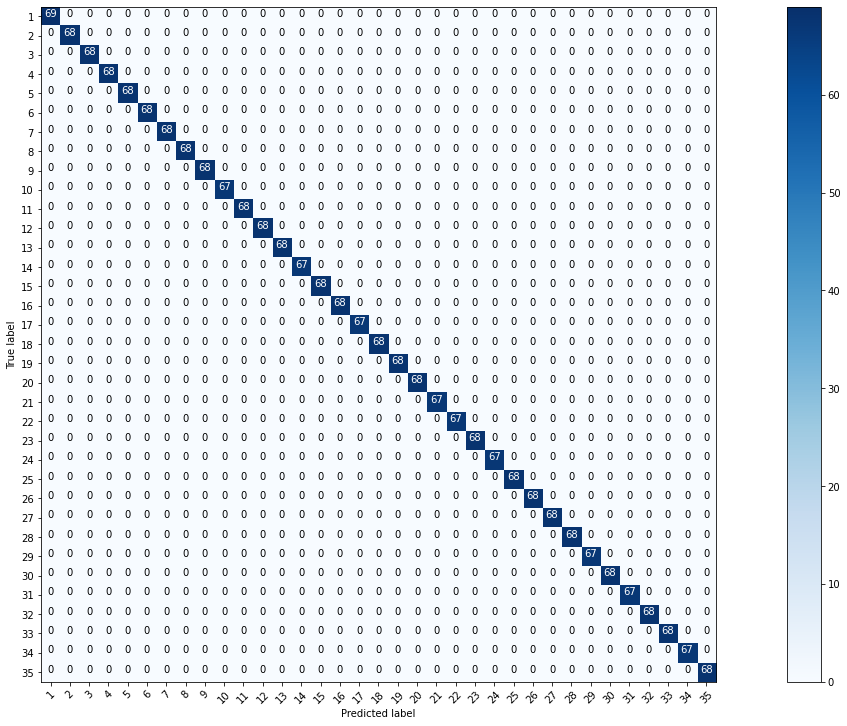

In [39]:
labels_names=["1", "2","3","4","5",
            "6", "7","8","9","10",
            "11", "12","13","14","15",
            "16", "17","18","19","20",
            "21", "22","23","24","25",
            "26", "27","28","29","30",
            "31", "32","33","34","35"]

plt.figure(figsize=(20,10))
fig = plot_confusion_matrix(cmt, labels_names)


plt.savefig('output2_test_BDSL.png', dpi=300)

In [40]:
cm[0][1]

0

In [41]:
total =0
for i in range(35):

    total = total+cm[0][i]
        
print(total)

69


In [42]:
100.0* cm[0][0] / total

100.0

In [43]:
newdata = cm.diagonal()/cm.sum(axis=1)

In [44]:
newdata*100

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.])

In [45]:
for i in range(35):
    print(f'Class {i+10} acc is {newdata[i]*100:.2f} %')

Class 10 acc is 100.00 %
Class 11 acc is 100.00 %
Class 12 acc is 100.00 %
Class 13 acc is 100.00 %
Class 14 acc is 100.00 %
Class 15 acc is 100.00 %
Class 16 acc is 100.00 %
Class 17 acc is 100.00 %
Class 18 acc is 100.00 %
Class 19 acc is 100.00 %
Class 20 acc is 100.00 %
Class 21 acc is 100.00 %
Class 22 acc is 100.00 %
Class 23 acc is 100.00 %
Class 24 acc is 100.00 %
Class 25 acc is 100.00 %
Class 26 acc is 100.00 %
Class 27 acc is 100.00 %
Class 28 acc is 100.00 %
Class 29 acc is 100.00 %
Class 30 acc is 100.00 %
Class 31 acc is 100.00 %
Class 32 acc is 100.00 %
Class 33 acc is 100.00 %
Class 34 acc is 100.00 %
Class 35 acc is 100.00 %
Class 36 acc is 100.00 %
Class 37 acc is 100.00 %
Class 38 acc is 100.00 %
Class 39 acc is 100.00 %
Class 40 acc is 100.00 %
Class 41 acc is 100.00 %
Class 42 acc is 100.00 %
Class 43 acc is 100.00 %
Class 44 acc is 100.00 %
